# Lightricks Challenge - DataHack 2018

In [135]:
import os
import sys
import operator
import numpy as np
import pandas as pd
import scipy
import dateutil
from sklearn.model_selection import train_test_split,KFold,cross_val_score
# from sklearn.cross_validation import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [3]:
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
path = './'
teamname = 'MadeInJerusalem'
out_name = path + teamname + '_submission.csv'

In [5]:
df_usage = pd.read_csv(path + "train_usage_data.csv")

In [6]:
#Looking data format and types
df_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393138 entries, 0 to 393137
Data columns (total 5 columns):
id                393138 non-null int64
feature_name      393138 non-null object
usage_duration    393138 non-null float64
use_date          393138 non-null object
accepted          393138 non-null bool
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 12.4+ MB


The variables in dataframe "df_usage" are:

| Field name   | Description | 
|----------|-------------|
| id | User ID |
| feature_name | Name of feature used |
| usage_duration | Duration in seconds between feature was entered and accepted or canceled |
| use_date | Date and time when the feature was entered |
| accepted | True if the user accepted the changes by the feature and False if he did not accepted the changes |

In [7]:
df_usage.head()

,id,feature_name,usage_duration,use_date,accepted
0,420000380263334,Prism,4.233,2018-04-27 16:19:50,False
1,370000259367972,Darkroom,7.071,2018-04-22 10:11:05,False
2,550000326477715,Darkroom,37.881,2018-04-30 09:50:29,False
3,440000406578453,Prism,17.580,2018-04-02 00:25:46,False
4,150000389301639,Eyes,1.620,2018-04-20 16:39:48,False


In [8]:
df_users = pd.read_csv(path + "train_users_data.csv",parse_dates = [ 'installation_date','subscripiton_date'])

In [9]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8311 entries, 0 to 8310
Data columns (total 7 columns):
Unnamed: 0           8311 non-null int64
id                   8311 non-null int64
installation_date    8311 non-null datetime64[ns]
subscripiton_date    8311 non-null datetime64[ns]
country              8309 non-null object
days_until_churn     1970 non-null float64
churned              8311 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 454.6+ KB


In [10]:
df_users.head()

,Unnamed: 0,id,installation_date,subscripiton_date,country,days_until_churn,churned
0,1,100000415577994,2017-07-16 22:29:31,2018-04-01 01:35:58,Canada,NaN,0
1,2,100000415580508,2016-12-19 14:28:03,2018-04-01 01:45:40,New Zealand,NaN,0
2,3,100000415636784,2017-02-09 00:48:33,2018-04-01 05:15:46,United States,NaN,0
3,4,100000415750897,2017-12-07 16:03:47,2018-04-01 13:27:22,Turkey,NaN,0
4,5,100000415825030,2017-12-01 14:59:29,2018-04-01 17:23:33,United States,9.0,1


The variables in dataframe "df_users" are:

| Field name   | Description | 
|----------|-------------|
| id | User ID |
| installation_date | Date and time when the application was first installed |
| subscription_date | Date and time when the user joined as a subscriber |
| country | Country where the user is based |
| days_until_churned | Days before the user decided to leave the subscription (churn). NaN if the user has not churned |
| churned | False if the user is still a subscriber and True if the user stopped his subscription. |

In [11]:
df_users = df_users.drop(columns='Unnamed: 0')
df_users.head()

,id,installation_date,subscripiton_date,country,days_until_churn,churned
0,100000415577994,2017-07-16 22:29:31,2018-04-01 01:35:58,Canada,NaN,0
1,100000415580508,2016-12-19 14:28:03,2018-04-01 01:45:40,New Zealand,NaN,0
2,100000415636784,2017-02-09 00:48:33,2018-04-01 05:15:46,United States,NaN,0
3,100000415750897,2017-12-07 16:03:47,2018-04-01 13:27:22,Turkey,NaN,0
4,100000415825030,2017-12-01 14:59:29,2018-04-01 17:23:33,United States,9.0,1


# Data exploration:

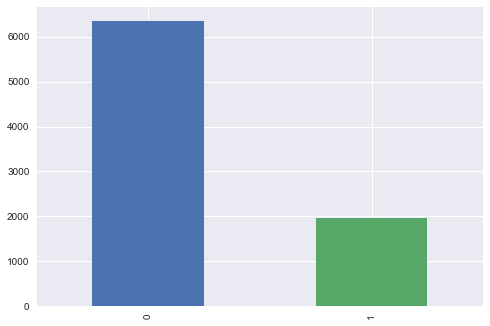

In [12]:
df_users['churned'].value_counts().plot('bar')

In [13]:
joined_df = df_usage.join(df_users.set_index('id'),on='id')

In [14]:
joined_df.head()

,id,feature_name,usage_duration,use_date,accepted,installation_date,subscripiton_date,country,days_until_churn,churned
0,420000380263334,Prism,4.233,2018-04-27 16:19:50,False,2018-04-27 16:07:01,2018-04-27 16:14:42,United States,NaN,0
1,370000259367972,Darkroom,7.071,2018-04-22 10:11:05,False,2018-04-04 20:08:02,2018-04-05 07:13:01,United Kingdom,NaN,0
2,550000326477715,Darkroom,37.881,2018-04-30 09:50:29,False,2018-04-27 08:11:24,2018-04-30 09:47:27,Greece,NaN,0
3,440000406578453,Prism,17.580,2018-04-02 00:25:46,False,2018-04-01 23:08:44,2018-04-01 23:34:53,United States,NaN,0
4,150000389301639,Eyes,1.620,2018-04-20 16:39:48,False,2017-03-14 03:52:36,2018-04-19 16:06:58,United States,NaN,0


In [15]:
total_number_of_usage_per_feature = df_usage['feature_name'].value_counts()
total_number_of_usage_per_feature.shape

(17,)

In [16]:
k = 10
top_k_features_churned = joined_df[joined_df['churned']==True]['feature_name'].value_counts().index[:k]
top_k_features_not_churned = joined_df[joined_df['churned']==False]['feature_name'].value_counts().index[:k]

In [17]:
top_k_features_not_churned

Index(['Filters', 'Darkroom', 'Prism', 'Reshape', 'Face', 'Defocus',
       'Backdrop', 'Paint', 'Relight', 'Eyes'],
      dtype='object')

In [18]:
df_churned = joined_df[(joined_df['churned']==True) & (joined_df['accepted']==True)]
df_churned.head()

,id,feature_name,usage_duration,use_date,accepted,installation_date,subscripiton_date,country,days_until_churn,churned
15198,110000398440704,Filters,48.944,2018-04-06 01:55:22,True,2018-03-12 20:44:17,2018-04-06 00:12:10,United States,7.0,1
15205,600000284617989,Eyes,2.276,2018-04-18 05:42:03,True,2018-04-17 20:49:17,2018-04-18 00:56:09,United States,21.0,1
15211,170000449701758,Darkroom,46.341,2018-04-24 16:34:30,True,2018-04-24 13:55:08,2018-04-24 16:32:25,United Kingdom,1.0,1
15215,380000303632483,Paint,1.259,2018-04-27 20:49:15,True,2018-04-27 20:36:36,2018-04-27 20:42:59,United States,1.0,1
15236,450000381370671,Darkroom,15.237,2018-04-29 01:07:00,True,2018-04-05 19:43:00,2018-04-05 20:16:50,United States,1.0,1


C:\Programs\Anaconda\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


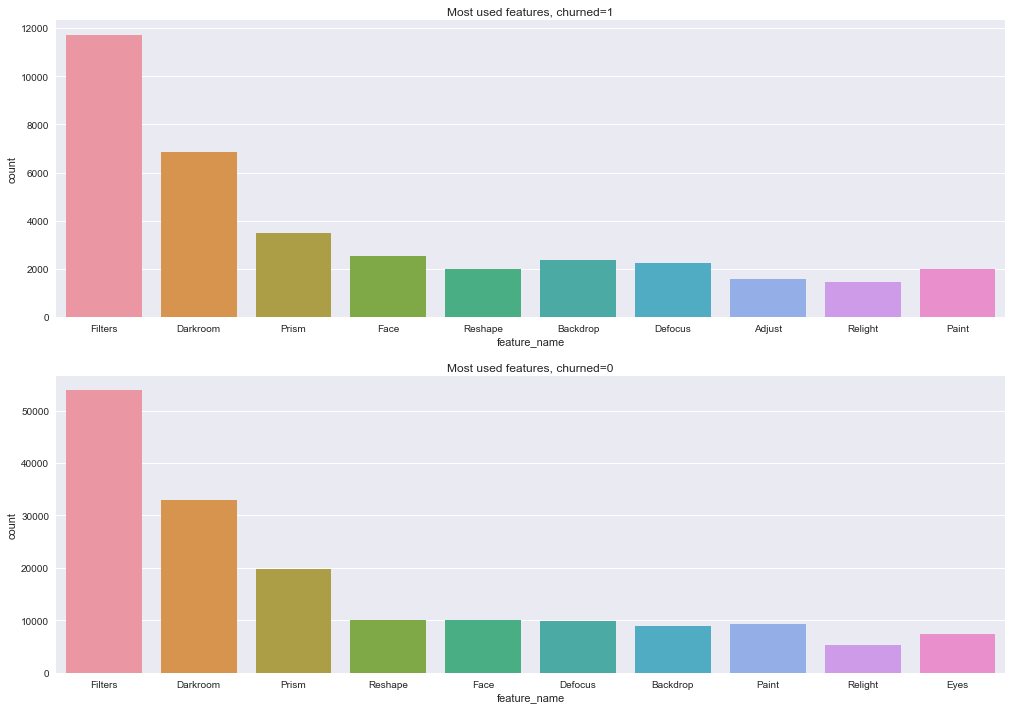

In [19]:
#What are the most popular features, within each class:

#total_number_of_usage_per_feature = df_usage['feature_name'].value_counts()



# k = 10
# top_k_features_churned = joined_df[joined_df['churned']==True]['feature_name'].value_counts().index[:k]
# top_k_features_not_churned = joined_df[joined_df['churned']==False]['feature_name'].value_counts().index[:k]


fig, ax = plt.subplots(2,1, figsize=(17,12))
df_churned = joined_df[(joined_df['churned']==True) & (joined_df['accepted']==True)]
p = sns.countplot(data=df_churned[df_churned['feature_name'].isin(top_k_features_churned)], x='feature_name', order = top_k_features_churned, ax=ax[0])

df_not_churned = joined_df[(joined_df['churned']==False) & (joined_df['accepted']==True)]
q = sns.countplot(data=df_not_churned[df_not_churned['feature_name'].isin(top_k_features_not_churned)], x='feature_name', order = top_k_features_not_churned, ax=ax[1])

ax[0].set_title('Most used features, churned=1')
ax[1].set_title('Most used features, churned=0')

In [20]:
groupedDf = joined_df.groupby(['id', 'churned', 'feature_name'])
groupedDf.mean().head()

usage_duration  accepted  \
id             churned feature_name                             
20000443246052 0       Adjust             18.314889  0.333333   
                       Backdrop            9.859667  0.333333   
                       Crop                4.827750  0.500000   
                       Darkroom           26.927308  0.538462   
                       Defocus            10.345636  0.909091   

                                     days_until_churn  
id             churned feature_name                    
20000443246052 0       Adjust                     NaN  
                       Backdrop                   NaN  
                       Crop                       NaN  
                       Darkroom                   NaN  
                       Defocus                    NaN

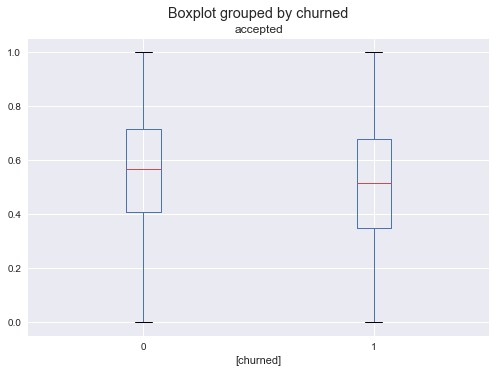

In [21]:
joined_df.groupby(['id', 'churned'])[['accepted']].mean().boxplot(by='churned')

# TODO: Filter outliers

In [22]:
#end_of_time_series = np.log(joined_df['usage_duration']).hist()
joined_df = joined_df[joined_df['usage_duration']<200]

# Creating our input data:

In [37]:
# Add time statistics
start_of_time_series = joined_df['subscripiton_date'].min()
print(start_of_time_series)
end_of_time_series = joined_df['use_date'].max()
print(end_of_time_series)
date_features = joined_df[['id','installation_date','subscripiton_date','use_date']].groupby('id').max()
date_features['days_installed'] = (pd.to_datetime(end_of_time_series) - date_features['installation_date']).dt.days
date_features['days_installed_not_subscribed'] = (date_features['subscripiton_date'] - date_features['installation_date']).dt.days
date_features['days_since_last_use'] = (pd.to_datetime(end_of_time_series) - pd.to_datetime(date_features['use_date'])).dt.days
date_features['days_used'] = np.minimum((pd.to_datetime(date_features['use_date']) - date_features['installation_date']).dt.days, 
                                        (pd.to_datetime(date_features['use_date']) - pd.to_datetime(start_of_time_series) ).dt.days)
date_features = date_features[['days_installed','days_installed_not_subscribed','days_since_last_use','days_used']]
date_features.head()

2018-04-01 00:02:30
2018-05-13 03:28:28


,days_installed,days_installed_not_subscribed,days_since_last_use,days_used
id,,,,
20000443246052,164,123,14,28
20000443252617,480,438,32,10
20000443310150,41,0,41,0
20000443405819,259,217,14,28
20000443434193,41,0,41,0


In [38]:
# extract mean usage time for FaceTune features
users_mean_usage_time = pd.pivot_table(joined_df[['id', 'feature_name', 'usage_duration']], values='usage_duration', index=['id'], columns=['feature_name'], aggfunc=np.mean, fill_value=0)
users_mean_usage_time = users_mean_usage_time.add_suffix('_mean_time')
users_mean_usage_time.head()

feature_name,Adjust_mean_time,Backdrop_mean_time,Crop_mean_time,Darkroom_mean_time,Defocus_mean_time,Eyes_mean_time,Face_mean_time,Filters_mean_time,Light FX_mean_time,Paint_mean_time,Patch_mean_time,Prism_mean_time,Relight_mean_time,Reshape_mean_time,Retouch_mean_time,Touch Up_mean_time,Vignette_mean_time
id,,,,,,,,,,,,,,,,,
20000443246052,18.314889,9.859667,4.82775,26.927308,10.345636,4.691,20.593333,16.218000,23.652667,4.7785,0.0,19.676957,21.21975,29.730667,22.314375,6.6825,7.97975
20000443252617,34.730000,14.218900,3.84700,11.408176,14.833333,0.000,58.266571,64.251875,2.308500,0.0000,0.0,0.000000,6.79750,26.539500,0.000000,0.0000,0.00000
20000443310150,24.272000,79.271667,0.00000,8.871000,0.000000,59.081,48.072167,42.506667,0.000000,0.0000,0.0,0.000000,69.82350,73.265500,0.000000,5.3110,0.00000
20000443405819,28.361000,0.000000,0.00000,26.386750,44.532500,0.000,60.734000,39.617500,2.230000,7.3765,0.0,37.679000,2.28000,7.504500,0.000000,1.8730,0.00000
20000443434193,0.000000,0.000000,0.00000,3.159000,0.000000,0.000,0.000000,86.108333,0.000000,0.0000,0.0,0.000000,0.00000,0.000000,0.000000,0.0000,0.00000


In [39]:
# extract mean acceptance rate for FaceTune features
users_mean_acceptance_rate = pd.pivot_table(joined_df[['id', 'feature_name', 'accepted']], values='accepted', index=['id'], columns=['feature_name'], aggfunc=np.mean, fill_value=0)
users_mean_acceptance_rate = users_mean_acceptance_rate.add_suffix('_mean_acceptance')
users_mean_acceptance_rate.head()

feature_name,Adjust_mean_acceptance,Backdrop_mean_acceptance,Crop_mean_acceptance,Darkroom_mean_acceptance,Defocus_mean_acceptance,Eyes_mean_acceptance,Face_mean_acceptance,Filters_mean_acceptance,Light FX_mean_acceptance,Paint_mean_acceptance,Patch_mean_acceptance,Prism_mean_acceptance,Relight_mean_acceptance,Reshape_mean_acceptance,Retouch_mean_acceptance,Touch Up_mean_acceptance,Vignette_mean_acceptance
id,,,,,,,,,,,,,,,,,
20000443246052,0.333333,0.333333,0.5,0.538462,0.909091,1.000000,0.666667,0.844444,0.666667,0.0,0.0,0.565217,0.5,0.50,1.0,0.5,0.75
20000443252617,0.000000,0.700000,0.0,0.235294,0.666667,0.000000,0.571429,0.500000,0.000000,0.0,0.0,0.000000,0.5,0.00,0.0,0.0,0.00
20000443310150,0.000000,0.666667,0.0,0.000000,0.000000,0.666667,0.166667,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.00
20000443405819,0.500000,0.000000,0.0,0.250000,0.500000,0.000000,0.500000,0.375000,0.000000,0.5,0.0,0.333333,0.0,0.00,0.0,0.0,0.00
20000443434193,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00


In [40]:
#Let's create a table with statistic summaries: rows correspond to users; columns to various statistics:
users_usage_summaries = pd.pivot_table(joined_df[['id', 'feature_name']], index=['id'], columns=['feature_name'], aggfunc=len, fill_value=0)
users_usage_summaries.head()

feature_name,Adjust,Backdrop,Crop,Darkroom,Defocus,Eyes,Face,Filters,Light FX,Paint,Patch,Prism,Relight,Reshape,Retouch,Touch Up,Vignette
id,,,,,,,,,,,,,,,,,
20000443246052,9,3,4,26,11,2,6,45,3,2,0,23,4,18,8,2,4
20000443252617,1,10,2,17,3,0,7,16,2,0,0,0,2,4,0,0,0
20000443310150,1,3,0,3,0,3,6,3,0,0,0,0,2,4,0,1,0
20000443405819,2,0,0,4,2,0,2,8,1,2,0,6,1,2,0,1,0
20000443434193,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0


In [41]:
#Let's add the mean of 'accepted' for each user:
accepted_rate = joined_df.groupby(['id'])['accepted'].mean().to_frame()
accepted_rate.head()

,accepted
id,
20000443246052,0.658824
20000443252617,0.406250
20000443310150,0.230769
20000443405819,0.322581
20000443434193,0.750000


In [66]:
# Add labels
churned = joined_df.groupby(['id'])['churned'].mean().to_frame()
churned.head()

,churned
id,
20000443246052,0
20000443252617,0
20000443310150,0
20000443405819,0
20000443434193,0


In [172]:
#Assemble all the features
#total_features = users_usage_summaries.join(accepted_rate, how='left').join(churned, how='left')
total_features = users_usage_summaries.join(users_mean_usage_time, how='left').join(users_mean_acceptance_rate, how='left').join(date_features, how='left').join(accepted_rate, how='left').join(churned, how='left')

#This is how our df looks like:
total_features.shape


(8241, 57)

In [110]:
#number_of_churned = total_features[total_features['churned']==True].shape[0]
#churned_samples = total_features[total_features['churned']==True]
#not_churned_samples = total_features[total_features['churned']==False].sample(n=number_of_churned)
#total_features = pd.concat([churned_samples, not_churned_samples]).sample(frac=1)
#This is how our df looks like:
#total_features.shape

# Learn a decision tree:

In [178]:
algo = make_pipeline(preprocessing.MinMaxScaler(), svm.LinearSVC(class_weight='balanced'))
scores = cross_val_score(algo, X, y, cv=5, scoring='f1')
scores.mean()
print(np.round(scores.mean(),3))

0.391


In [173]:
X = total_features.iloc[:, total_features.columns!='churned'].values
y = total_features.loc[:,'churned'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [179]:
#algo=tree.DecisionTreeClassifier(criterion='entropy',max_depth = 8)
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
algo  = svm.LinearSVC(class_weight='balanced')
train = algo.fit(X_train_scaled, y_train)
X_val_scaled = scaler.transform(X_val)
res_train=train.predict(X_train_scaled)
res=train.predict(X_val_scaled)
print(res)

[0 1 1 ..., 0 0 1]


In [180]:
#Let's check the confusion matrix:
cm = metrics.confusion_matrix(y_train, res_train)
print(cm)
print(classification_report(y_pred=res_train,y_true=y_train))
# print only f1 score for positive
print(np.round(f1_score(y_pred=res_train,y_true=y_train),3))

[[2485 1900]
 [ 534  849]]
             precision    recall  f1-score   support

          0       0.82      0.57      0.67      4385
          1       0.31      0.61      0.41      1383

avg / total       0.70      0.58      0.61      5768

0.411


In [181]:
#Let's check the confusion matrix:
cm = metrics.confusion_matrix(y_val, res)
print(cm)
print(classification_report(y_pred=res,y_true=y_val))
# print only f1 score for positive
print(np.round(f1_score(y_pred=res,y_true=y_val),3))

[[1046  850]
 [ 240  337]]
             precision    recall  f1-score   support

          0       0.81      0.55      0.66      1896
          1       0.28      0.58      0.38       577

avg / total       0.69      0.56      0.59      2473

0.382


In [134]:
#test your predictor:

#1.Prepare your test-set (in case you created new features/transformed the input data):
df_usage_test = pd.read_csv("test_usage_data.csv")
users_usage_summaries_test = pd.pivot_table(df_usage_test[['id', 'feature_name']], index=['id'], columns=['feature_name'], aggfunc=len, fill_value=0)

accepted_rate_test = df_usage_test.groupby(['id'])['accepted'].mean().to_frame()

#Let's merge the two:
users_usage_summaries_test = users_usage_summaries_test.join(accepted_rate_test, how='left')
X_test = users_usage_summaries_test.values

In [135]:
users_usage_summaries

,Adjust,Backdrop,Crop,Darkroom,Defocus,Eyes,Face,Filters,Light FX,Paint,...,Reshape_mean_acceptance,Retouch_mean_acceptance,Touch Up_mean_acceptance,Vignette_mean_acceptance,days_installed,days_installed_not_subscribed,days_since_last_use,days_used,accepted,churned
id,,,,,,,,,,,,,,,,,,,,,
20000443246052,9,3,4,26,11,2,6,45,3,2,...,0.500000,1.000000,0.500000,0.750000,164,123,14,28,0.658824,0
20000443252617,1,10,2,17,3,0,7,16,2,0,...,0.000000,0.000000,0.000000,0.000000,480,438,32,10,0.406250,0
20000443310150,1,3,0,3,0,3,6,3,0,0,...,0.250000,0.000000,0.000000,0.000000,41,0,41,0,0.230769,0
20000443405819,2,0,0,4,2,0,2,8,1,2,...,0.000000,0.000000,0.000000,0.000000,259,217,14,28,0.322581,0
20000443434193,0,0,0,1,0,0,0,3,0,0,...,0.000000,0.000000,0.000000,0.000000,41,0,41,0,0.750000,0
20000443469779,2,2,13,35,20,9,4,17,11,4,...,0.666667,0.777778,0.166667,1.000000,196,155,13,28,0.672131,0
20000443895994,1,15,0,43,9,0,0,29,0,0,...,0.600000,0.000000,0.000000,0.000000,41,1,13,27,0.532710,0
20000443935569,7,0,0,1,2,1,2,4,1,3,...,0.500000,1.000000,0.000000,1.000000,39,0,39,0,0.387097,1
20000444138744,0,1,0,3,3,0,0,8,0,1,...,0.000000,0.000000,0.000000,0.000000,59,20,38,3,0.555556,1


In [136]:
#submit result:
pred = train.predict(X_test)
df = pd.DataFrame(pred, index=users_usage_summaries_test.index.astype(str), columns=['churned'], dtype=str)
df.to_csv(out_name, header=True, quoting=csv.QUOTE_NONNUMERIC) 

ValueError: X has 18 features per sample; expecting 56